# Dengue Prediction from Weather and Google Keyword Search by Machine Leaning

Notebook Navigation:
1. Data Scraping
2. **Dataset Overview, Data Preprocessing, and EDA**
    - [Background](#background)
    - [Problem Statement](#problem-statement)
    - [Dataset First Look](#dataset-first-look)
    - [Data Preprocessing](#data-preprocessinng)
    - [Exploratory Data Analysis](#exploratory-data-analysis)
3. Modeling, Tuning, Cost Based Analysis and Recommendation

In [1531]:
# Import
import datetime as dt
from datetime import datetime
import pandas as pd
import numpy as np
from datetime import timedelta
from statsmodels.tsa.api import VAR
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tools.eval_measures import rmse, aic
import statsmodels.api as sm
from pmdarima import auto_arima
from arch import arch_model
import seaborn as sns
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler,OneHotEncoder

## Background

Dengue fever is a disease transmitted through the bite of infective Aedes mosquito with 8-12 days incubation period while symptoms tend to develop after 4-7 days incubation period. Symptoms include fever for up to 7 days, headache, skin rash, nausea, mild bleeding, muscle and joint pain, but severe case can even lead to death.
 
It was first reported in Singapore in 1901 and the first outbreak was recorded in 1960 with 70 hospitalized case followed by 2013-2014 dengue outbreak where the number rose to up to almost 23,000 and the highest among all at 2020, contributed by the COVID pandemic where people stayed at home, at more than 35,000 cases recorded.

Indivual prevention methods such as applying mosquito repellent, wearing long covered clothing, or sleeping under mosquito nets definitely encouraged. However, the most important way to prevent the outbreak must start from the root of the problem, **preventing mosquito breeding habitats**.
 
Since then, National Environment Agency (NEA) has launched Dengue Prevention Programs on 30 march 20222. Preceeding programs include:
- Islandwide inspection to remove potential mosquito breeding habitats togeter with Inter Agency Dengue Task Force (IADTF)
- Sharing prevemtion method to member of public and Town Councils
- Fogging
- Project Wolbachia, launched in July 2020 to control mosquito breeding by releasing male Wolbachia infected mosquitos to breed with female Aesdes mosquito and their eggs won't hatch. [A "mosquito factory" in Ang Mo Kio was openned in 2019 with a whopping $5 million](https://www.straitstimes.com/singapore/health/about-200m-wolbachia-aedes-mosquitoes-released-from-mosquito-factory-nea). Although this is an exploratory approach, the sentiment towards this project is very positive.

## Problem Statement   

Government has allocated budget for each department every year. Large scale field trial for Wolbachia Aedes technology has been granted as a prevention method. However, as part of NEA, we would like to ensure that we have fogging measure as well as it is recommended where there is an increased presence of adult mosquitoes (which can be accelerated if an individual is infected with dengue) creating the need to eliminate infective mosquitoes immediately during a dengue or other mosquito-borne disease outbreak. Due to limited budget, **our team has been tasked to proposed effective fogging plan.**

In this project, as part of Data Science team in NEA, we will be forecasting dengue case by using machine learning on Singapore weather data, Google Trend (based on certain google search keywords) and dengue case data from Jul'2015 to Dec'2019

## Dataset First Look

In this project, there are 5 datasets to be used. Data collection duration for each data set might defer, which we must take note while using these datasets. 

|Dataset|Source|Column|Remarks|
|---|---|---|---|
|Singapore Historical Weather Data|[Meteorological Service Singapore](http://www.weather.gov.sg/climate-historical-daily/)|<li> Location <li> Date (daily)<li> Daily Rainfall<li> Temperature<li> Wind speed|<li> Potential issue due to a lot of missing values on certain areas|
|Specific Keywords Google Trend Analysis|[Google Trend](https://trends.google.com/trends/explore?date=today%205-y&geo=SG&q=%2Fm%2F09wsg)|<li> Date (month)<li> Number|Numbers represent search interest relative to the highest point (100) on the chart for the given region and time. 5 keywords: dengue fever, headache, nausea, mosquito bite, skin rash|
|Singapore Dengue Clusters Data Based on Clusters|[SG Outbreak](https://outbreak.sgcharts.com/data)|<li> Number of cases <li> Street address <li> Latitude <li> Longitude <li> Cluster Number <li> Recent Case in Cluster <li> Total Case in Cluster <li> Date (twice a week)|<li> Collected twice a week <li> Referencing to [NEA Data](https://www.nea.gov.sg/dengue-zika/dengue/dengue-clusters) <li> As per stated in source website: not guarantee perfect conversion because of dirty data e.g. wrong / misspelled / duplicate addresses. *Will be used as features due to data integrity*|
|Singapore Weekly Number of Dengue and Dengue Haemorrhagic Fever(DHF)|[data.gov.sg](https://data.gov.sg/dataset/weekly-number-of-dengue-and-dengue-haemorrhagic-fever-cases)|<li> Date: weekly 2014-01 to 2018-52<li> Dengue Type<li> Number of case|It is an official data from government and used as the target variable as we observe discrepancy of number of cases from outbreak.sg source.|
|Singapore County Data|Google API|<li>Station <li> Region|Classifying weather stations to Central, Northeast, Northwest, Southeast, Southwest|

Some of the dataset can be cleaner and how their collection date might differ from one another, therefore, in the next session we will be doing data cleaning from the data that we obtained previously.

## Data Preprocessinng

#### Weather Data

In [1532]:
# reading csv file of weather data
wt_df = pd.read_csv(r'../data/weather_data_check.csv')
wt_df = wt_df.drop(['Unnamed: 0'], axis=1)
wt_df.head()

,Station,Year,Month,Day,Daily Rainfall Total (mm),Highest 30 min Rainfall (mm),Highest 60 min Rainfall (mm),Highest 120 min Rainfall (mm),Mean Temperature (°C),Maximum Temperature (°C),Minimum Temperature (°C),Mean Wind Speed (km/h),Max Wind Speed (km/h)
0,Admiralty,2015,1,1,0.0,0.0,0.0,0.0,25.8,27.2,24.7,11.5,32.8
1,Admiralty,2015,1,2,0.0,0.0,0.0,0.0,26.6,29.5,24.7,13.9,38.2
2,Admiralty,2015,1,3,0.0,0.0,0.0,0.0,26.8,30.3,24.2,13.2,36.4
3,Admiralty,2015,1,4,0.0,0.0,0.0,0.0,27.1,31.1,24.6,12.1,34.2
4,Admiralty,2015,1,5,0.0,0.0,0.0,0.0,27.5,31.8,24.5,9.9,30.2


In [1533]:
# data cleaning and transformation
df_obj = wt_df.select_dtypes(['object'])

# stripe empty space before tranform data types to numeric
wt_df[df_obj.columns] = df_obj.apply(lambda x: x.str.strip())

# cleaning up some of the data
wt_df = wt_df.replace('\x97', '')
wt_df = wt_df.replace(r'^\s*$', np.nan, regex=True)
wt_df = wt_df.replace(r'-', np.nan, regex=True)
wt_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90415 entries, 0 to 90414
Data columns (total 13 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   Station                        90415 non-null  object
 1   Year                           90415 non-null  int64 
 2   Month                          90415 non-null  int64 
 3   Day                            90415 non-null  int64 
 4   Daily Rainfall Total (mm)      87080 non-null  object
 5   Highest 30 min Rainfall (mm)   80180 non-null  object
 6   Highest 60 min Rainfall (mm)   80180 non-null  object
 7   Highest 120 min Rainfall (mm)  80180 non-null  object
 8   Mean Temperature (°C)          30178 non-null  object
 9   Maximum Temperature (°C)       32964 non-null  object
 10  Minimum Temperature (°C)       32960 non-null  object
 11  Mean Wind Speed (km/h)         34237 non-null  object
 12  Max Wind Speed (km/h)          34131 non-null  object
dtypes

In [1534]:
# data type transformation
wt_df['Daily Rainfall Total (mm)'] = wt_df['Daily Rainfall Total (mm)'].astype(float)
wt_df['Mean Temperature (°C)'] = wt_df['Mean Temperature (°C)'].astype(float)
wt_df['Mean Wind Speed (km/h)'] = wt_df['Mean Wind Speed (km/h)'].astype(float)
wt_df['Highest 30 min Rainfall (mm)'] = wt_df['Highest 30 min Rainfall (mm)'].astype(float)
wt_df['Highest 60 min Rainfall (mm)'] = wt_df['Highest 60 min Rainfall (mm)'].astype(float)
wt_df['Highest 120 min Rainfall (mm)'] = wt_df['Highest 120 min Rainfall (mm)'].astype(float)
wt_df['Maximum Temperature (°C)'] = wt_df['Maximum Temperature (°C)'].astype(float)
wt_df['Minimum Temperature (°C)'] = wt_df['Minimum Temperature (°C)'].astype(float)
wt_df['Max Wind Speed (km/h)'] = wt_df['Max Wind Speed (km/h)'].astype(float)

# add a dataframe field
wt_df["Year"] = wt_df["Year"].astype(str)
wt_df["Month"] = wt_df["Month"].astype(str)
wt_df["Day"] = wt_df["Day"].astype(str)
wt_df["Date"] = pd.to_datetime(wt_df["Year"] + "/" + wt_df["Month"] + "/" + wt_df["Day"])

#take those from Jul'2015 to Dec'2019
wt_df = wt_df[(wt_df['Date'] >= '2015-07-01')&(wt_df['Date'] <= '2019-12-31')]
wt_df.head()

,Station,Year,Month,Day,Daily Rainfall Total (mm),Highest 30 min Rainfall (mm),Highest 60 min Rainfall (mm),Highest 120 min Rainfall (mm),Mean Temperature (°C),Maximum Temperature (°C),Minimum Temperature (°C),Mean Wind Speed (km/h),Max Wind Speed (km/h),Date
181,Admiralty,2015,7,1,0.2,0.2,0.2,0.2,28.2,30.0,24.1,6.0,43.2,2015-07-01
182,Admiralty,2015,7,2,4.0,4.0,4.0,4.0,28.9,32.2,26.7,5.8,31.0,2015-07-02
183,Admiralty,2015,7,3,0.0,0.0,0.0,0.0,29.2,32.4,27.1,7.3,28.1,2015-07-03
184,Admiralty,2015,7,4,16.2,12.0,14.0,15.8,27.4,29.1,23.5,6.9,54.0,2015-07-04
185,Admiralty,2015,7,5,0.0,0.0,0.0,0.0,29.4,33.6,26.7,7.0,28.4,2015-07-05


In [1535]:
def null_check(df):    
    percent_missing = df.isnull().sum() * 100 / df.shape[0]
    missing_value_df = pd.DataFrame({'percent_missing': percent_missing})
    return missing_value_df #heavy imputation process might skew our data especially Temperature and Wind Speed have a lot of null values
null_check(wt_df)

,percent_missing
Station,0.000000
Year,0.000000
Month,0.000000
Day,0.000000
Daily Rainfall Total (mm),3.962111
Highest 30 min Rainfall (mm),11.561993
Highest 60 min Rainfall (mm),11.561993
Highest 120 min Rainfall (mm),11.561993
Mean Temperature (°C),66.983636
Maximum Temperature (°C),63.804118


#### Handling Weather Missing Data


In [1536]:
#impute rainfall data as 0 for null values, assuming that 
rain = ['Daily Rainfall Total (mm)',
       'Highest 30 min Rainfall (mm)', 'Highest 60 min Rainfall (mm)',
       'Highest 120 min Rainfall (mm)']
for col in rain:
    wt_df[col].fillna(0,inplace=True)

In [1537]:
#impute temperature data as the average of that particular day
imp_col = ['Mean Temperature (°C)','Maximum Temperature (°C)','Minimum Temperature (°C)','Mean Wind Speed (km/h)','Max Wind Speed (km/h)']
for col in imp_col:
    wt_df[col] = wt_df[col].fillna(wt_df.groupby('Date')[col].transform('mean'))
null_check(wt_df)


,percent_missing
Station,0.0
Year,0.0
Month,0.0
Day,0.0
Daily Rainfall Total (mm),0.0
Highest 30 min Rainfall (mm),0.0
Highest 60 min Rainfall (mm),0.0
Highest 120 min Rainfall (mm),0.0
Mean Temperature (°C),0.0
Maximum Temperature (°C),0.0


#### Singapore County Data

In [1538]:
dis_df = pd.read_csv('../data/region_info.csv')
dis_df.rename(columns={'Area':'Station'},inplace=True)
dis_df

,Station,Region
0,Admiralty,Northwest
1,Admiralty West,Northwest
2,Ang Mo Kio,Central
3,Boon Lay (East),Southwest
4,Boon Lay (West),Southwest
...,...,...
58,Ulu Pandan,Southwest
59,Upper Peirce Reservoir,Central
60,Upper Thomson,Central
61,Whampoa,Central


In [1539]:
#merging it with weather data based on the station
w_df = pd.merge(wt_df, dis_df, how='left', left_on=['Station'], right_on=['Station'])
w_df.rename(columns={'Region':'County'},inplace=True)
w_df.head()

,Station,Year,Month,Day,Daily Rainfall Total (mm),Highest 30 min Rainfall (mm),Highest 60 min Rainfall (mm),Highest 120 min Rainfall (mm),Mean Temperature (°C),Maximum Temperature (°C),Minimum Temperature (°C),Mean Wind Speed (km/h),Max Wind Speed (km/h),Date,County
0,Admiralty,2015,7,1,0.2,0.2,0.2,0.2,28.2,30.0,24.1,6.0,43.2,2015-07-01,Northwest
1,Admiralty,2015,7,2,4.0,4.0,4.0,4.0,28.9,32.2,26.7,5.8,31.0,2015-07-02,Northwest
2,Admiralty,2015,7,3,0.0,0.0,0.0,0.0,29.2,32.4,27.1,7.3,28.1,2015-07-03,Northwest
3,Admiralty,2015,7,4,16.2,12.0,14.0,15.8,27.4,29.1,23.5,6.9,54.0,2015-07-04,Northwest
4,Admiralty,2015,7,5,0.0,0.0,0.0,0.0,29.4,33.6,26.7,7.0,28.4,2015-07-05,Northwest


#### Google Trend

Number is taken every month, however, we will be extrapolating it to weekly data to match our existing data.

In [1540]:
dengue_fever = pd.read_csv('../data/google_trend/dengue_fever_trend.csv')
head = pd.read_csv('../data/google_trend/headache_trend.csv') #dengue case symptoms
nausea = pd.read_csv('../data/google_trend/nausea_trend.csv') #dengue case symptoms
mosquito = pd.read_csv('../data/google_trend/mosquito_bite_trend.csv')
skin = pd.read_csv('../data/google_trend/skin_rash_trend.csv') #dengue case symptoms

In [1541]:
new_header = dengue_fever.iloc[0] #grab the first row for the header
dengue_fever = dengue_fever[1:] #take the data less the header row
dengue_fever.columns = new_header
dengue_fever.reset_index(inplace=True)
dengue_fever['index'] = dengue_fever['index'].apply(lambda x:datetime.strptime(x,'%Y-%m').date())
dengue_fever.head()

Month,index,Dengue fever: (Singapore)
0,2004-01-01,0
1,2004-02-01,13
2,2004-03-01,14
3,2004-04-01,0
4,2004-05-01,0


In [1542]:
new_header = head.iloc[0] #grab the first row for the header
head = head[1:] #take the data less the header row
head.columns = new_header
head.reset_index(inplace=True)
head['index'] = head['index'].apply(lambda x:datetime.strptime(x,'%Y-%m').date())
head.head()

Month,index,headache: (Singapore)
0,2004-01-01,0
1,2004-02-01,0
2,2004-03-01,40
3,2004-04-01,33
4,2004-05-01,37


In [1543]:
new_header = nausea.iloc[0] #grab the first row for the header
nausea = nausea[1:] #take the data less the header row
nausea.columns = new_header
nausea.reset_index(inplace=True)
nausea['index'] = nausea['index'].apply(lambda x:datetime.strptime(x,'%Y-%m').date())
nausea.head()

Month,index,Nausea: (Singapore)
0,2004-01-01,100
1,2004-02-01,0
2,2004-03-01,0
3,2004-04-01,76
4,2004-05-01,42


In [1544]:
new_header = mosquito.iloc[0] #grab the first row for the header
mosquito = mosquito[1:] #take the data less the header row
mosquito.columns = new_header
mosquito.reset_index(inplace=True)
mosquito['index'] = mosquito['index'].apply(lambda x:datetime.strptime(x,'%Y-%m').date())
mosquito.head()

Month,index,Mosquito bite: (Singapore)
0,2004-01-01,0
1,2004-02-01,46
2,2004-03-01,0
3,2004-04-01,0
4,2004-05-01,43


In [1545]:
new_header = skin.iloc[0] #grab the first row for the header
skin = skin[1:] #take the data less the header row
skin.columns = new_header
skin.reset_index(inplace=True)
skin['index'] = skin['index'].apply(lambda x:datetime.strptime(x,'%Y-%m').date())
skin.head()

Month,index,Skin rash: (Singapore)
0,2004-01-01,100
1,2004-02-01,65
2,2004-03-01,42
3,2004-04-01,67
4,2004-05-01,0


In [1546]:
trend_df = pd.merge(left=dengue_fever,right=head,on='index',how='left')
trend_df = pd.merge(left=trend_df,right=nausea,on='index',how='left')
trend_df = pd.merge(left=trend_df,right=mosquito,on='index',how='left')
trend_df = pd.merge(left=trend_df,right=skin,on='index',how='left')
trend_df.head() #monthly google trend based on keywords

Month,index,Dengue fever: (Singapore),headache: (Singapore),Nausea: (Singapore),Mosquito bite: (Singapore),Skin rash: (Singapore)
0,2004-01-01,0,0,100,0,100
1,2004-02-01,13,0,0,46,65
2,2004-03-01,14,40,0,0,42
3,2004-04-01,0,33,76,0,67
4,2004-05-01,0,37,42,43,0


In [1547]:
w_df.head()

,Station,Year,Month,Day,Daily Rainfall Total (mm),Highest 30 min Rainfall (mm),Highest 60 min Rainfall (mm),Highest 120 min Rainfall (mm),Mean Temperature (°C),Maximum Temperature (°C),Minimum Temperature (°C),Mean Wind Speed (km/h),Max Wind Speed (km/h),Date,County
0,Admiralty,2015,7,1,0.2,0.2,0.2,0.2,28.2,30.0,24.1,6.0,43.2,2015-07-01,Northwest
1,Admiralty,2015,7,2,4.0,4.0,4.0,4.0,28.9,32.2,26.7,5.8,31.0,2015-07-02,Northwest
2,Admiralty,2015,7,3,0.0,0.0,0.0,0.0,29.2,32.4,27.1,7.3,28.1,2015-07-03,Northwest
3,Admiralty,2015,7,4,16.2,12.0,14.0,15.8,27.4,29.1,23.5,6.9,54.0,2015-07-04,Northwest
4,Admiralty,2015,7,5,0.0,0.0,0.0,0.0,29.4,33.6,26.7,7.0,28.4,2015-07-05,Northwest


In [1555]:
#merging it based on month
trend_df['index'] = pd.to_datetime(trend_df['index'])
data = pd.merge(w_df.assign(grouper=w_df['Date'].dt.to_period('M')),
               trend_df.assign(grouper=trend_df['index'].dt.to_period('M')),
               how='left', on='grouper')
#cleaning up data set data type
data['Date']=pd.to_datetime(data['Date']).dt.strftime('%Y-%W')
data['Month'] = data['Month'].astype(int)
data['Dengue fever: (Singapore)'] = data['Dengue fever: (Singapore)'].astype(int)
data['headache: (Singapore)'] = data['headache: (Singapore)'].astype(int)
data['Nausea: (Singapore)'] = data['Nausea: (Singapore)'].astype(int)
data['Mosquito bite: (Singapore)'] = data['Mosquito bite: (Singapore)'].astype(int)
data['Skin rash: (Singapore)'] = data['Skin rash: (Singapore)'].astype(int)
data.head()

,Station,Year,Month,Day,Daily Rainfall Total (mm),Highest 30 min Rainfall (mm),Highest 60 min Rainfall (mm),Highest 120 min Rainfall (mm),Mean Temperature (°C),Maximum Temperature (°C),...,Max Wind Speed (km/h),Date,County,grouper,index,Dengue fever: (Singapore),headache: (Singapore),Nausea: (Singapore),Mosquito bite: (Singapore),Skin rash: (Singapore)
0,Admiralty,2015,7,1,0.2,0.2,0.2,0.2,28.2,30.0,...,43.2,2015-26,Northwest,2015-07,2015-07-01,16,72,57,5,60
1,Admiralty,2015,7,2,4.0,4.0,4.0,4.0,28.9,32.2,...,31.0,2015-26,Northwest,2015-07,2015-07-01,16,72,57,5,60
2,Admiralty,2015,7,3,0.0,0.0,0.0,0.0,29.2,32.4,...,28.1,2015-26,Northwest,2015-07,2015-07-01,16,72,57,5,60
3,Admiralty,2015,7,4,16.2,12.0,14.0,15.8,27.4,29.1,...,54.0,2015-26,Northwest,2015-07,2015-07-01,16,72,57,5,60
4,Admiralty,2015,7,5,0.0,0.0,0.0,0.0,29.4,33.6,...,28.4,2015-26,Northwest,2015-07,2015-07-01,16,72,57,5,60


In [1556]:
null_check(data) #no missing data

,percent_missing
Station,0.0
Year,0.0
Month,0.0
Day,0.0
Daily Rainfall Total (mm),0.0
Highest 30 min Rainfall (mm),0.0
Highest 60 min Rainfall (mm),0.0
Highest 120 min Rainfall (mm),0.0
Mean Temperature (°C),0.0
Maximum Temperature (°C),0.0


In [1560]:
w_df_reg = data.groupby(['Date','County'])[['Date','County','Month','Daily Rainfall Total (mm)','Highest 30 min Rainfall (mm)', 'Highest 60 min Rainfall (mm)',
       'Highest 120 min Rainfall (mm)', 'Mean Temperature (°C)',
       'Maximum Temperature (°C)', 'Minimum Temperature (°C)',
       'Mean Wind Speed (km/h)', 'Max Wind Speed (km/h)','Dengue fever: (Singapore)',
       'headache: (Singapore)', 'Nausea: (Singapore)',
       'Mosquito bite: (Singapore)', 'Skin rash: (Singapore)']].mean()
w_df_reg['Month'] = w_df_reg['Month'].astype(int)       
w_df_reg.head()

Month  Daily Rainfall Total (mm)  \
Date    County                                        
2015-26 Central        7                   6.463333   
        Northeast      7                   6.860000   
        Northwest      7                   5.417500   
        Southeast      7                   6.530909   
        Southwest      7                   4.781333   

                   Highest 30 min Rainfall (mm)  Highest 60 min Rainfall (mm)  \
Date    County                                                                  
2015-26 Central                        4.476667                      5.250000   
        Northeast                      5.540000                      6.420000   
        Northwest                      3.465000                      4.105000   
        Southeast                      4.341818                      5.065455   
        Southwest                      3.489333                      3.965333   

                   Highest 120 min Rainfall (mm)  Mean Temperature (°C)  \
Date    County                                                            
2015-26 Central                         6.023333              28.555819   
        Northeast                       6.850000              28.477763   
        Northwest                       4.490000              28.631469   
        Southeast                       5.689091              28.769282   
        Southwest                       4.746667              28.628187   

                   Maximum Temperature (°C)  Minimum Temperature (°C)  \
Date    County                                                          
2015-26 Central                   31.257000                 25.332417   
        Northeast                 31.337000                 25.305750   
        Northwest                 31.535000                 25.303125   
        Southeast                 31.212727                 25.747727   
        Southwest                 30.983200                 25.612533   

                   Mean Wind Speed (km/h)  Max Wind Speed (km/h)  \
Date    County                                                     
2015-26 Central                  8.925417              37.106583   
        Northeast                8.788750              36.678250   
        Northwest                9.283125              38.316875   
        Southeast                9.427727              36.126818   
        Southwest                9.201333              37.508533   

                   Dengue fever: (Singapore)  headache: (Singapore)  \
Date    County                                                        
2015-26 Central                         16.0                   72.0   
        Northeast                       16.0                   72.0   
        Northwest                       16.0                   72.0   
        Southeast                       16.0                   72.0   
        Southwest                       16.0                   72.0   

                   Nausea: (Singapore)  Mosquito bite: (Singapore)  \
Date    County                                                       
2015-26 Central                   57.0                         5.0   
        Northeast                 57.0                         5.0   
        Northwest                 57.0                         5.0   
        Southeast                 57.0                         5.0   
        Southwest                 57.0                         5.0   

                   Skin rash: (Singapore)  
Date    County                             
2015-26 Central                      60.0  
        Northeast                    60.0  
        Northwest                    60.0  
        Southeast                    60.0  
        Southwest                    60.0

In [1561]:
w_df_reg.to_csv('../data/weather_data_cleaned.csv')

#### SG Outbreak Dengue Data

In [1583]:
d_df = pd.read_csv('../data/dengue_by_quarter_suburb_county.csv')
#dropping unnecessary columns
d_df = d_df.drop(['Unnamed: 0','Unnamed: 0.1','Unnamed: 0.2','Unnamed: 0.3','Quarter'], axis=1)
#updating date to match our datetime format
d_df['Date'] = pd.to_datetime(d_df['Date'], format='%y%m%d',yearfirst=True)
d_df.sort_values(by='Date',inplace=True)
d_df = d_df[d_df['Date'] <= '2019-12-31'] #taking the one until Dec'2019
d_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38187 entries, 0 to 37963
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   Number Of Cases          38187 non-null  int64         
 1   Street Address           38187 non-null  object        
 2   Latitude                 38187 non-null  float64       
 3   Longitude                38187 non-null  float64       
 4   Cluster Number           38187 non-null  int64         
 5   Recent Cases In Cluster  38187 non-null  int64         
 6   Total Cases In Cluster   38187 non-null  int64         
 7   Date                     38187 non-null  datetime64[ns]
 8   Month Number             38187 non-null  int64         
 9   Suburb                   38019 non-null  object        
 10  County                   38184 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(5), object(3)
memory usage: 3.5+ MB


In [1584]:
d_df['Date']=pd.to_datetime(d_df['Date']).dt.strftime('%Y-%W')
d_df.head()

,Number Of Cases,Street Address,Latitude,Longitude,Cluster Number,Recent Cases In Cluster,Total Cases In Cluster,Date,Month Number,Suburb,County
0,7,bishan street 22 (block 233),1.358639,103.845259,1,24,83,2015-26,7,Bishan,Central
98,1,bedok reservoir view (the clearwater),1.337496,103.934178,20,2,2,2015-26,7,Bedok,Southeast
97,1,bedok reservoir view (aquarius by the park),1.338017,103.935880,20,2,2,2015-26,7,Bedok,Southeast
96,1,aljunied crescent (block 110),1.319943,103.884262,19,2,2,2015-26,7,Geylang,Southeast
95,1,aljunied crescent (block 100),1.320944,103.883992,19,2,2,2015-26,7,Geylang,Southeast


In [1585]:
case = d_df.groupby(['Date','County'])[['Date','County','Number Of Cases']].sum() #number of cases per county per week
cluster = d_df.groupby(['Date','County'])[['Cluster Number']].nunique() #number of cluster
dg_df = pd.merge(case, cluster, how='left', left_on=['Date','County'], right_on=['Date','County'])
dg_df.head()

Number Of Cases  Cluster Number
Date    County                                    
2015-26 Central                172               9
        Northeast               22               9
        Northwest               34              10
        Southeast               46              11
        Southwest               13               4

In [1586]:
df = pd.merge(dg_df, w_df_reg, how='left', left_on=['Date','County'], right_on=['Date','County'])
df.head()

Number Of Cases  Cluster Number  Month  \
Date    County                                              
2015-26 Central                172               9      7   
        Northeast               22               9      7   
        Northwest               34              10      7   
        Southeast               46              11      7   
        Southwest               13               4      7   

                   Daily Rainfall Total (mm)  Highest 30 min Rainfall (mm)  \
Date    County                                                               
2015-26 Central                     6.463333                      4.476667   
        Northeast                   6.860000                      5.540000   
        Northwest                   5.417500                      3.465000   
        Southeast                   6.530909                      4.341818   
        Southwest                   4.781333                      3.489333   

                   Highest 60 min Rainfall (mm)  \
Date    County                                    
2015-26 Central                        5.250000   
        Northeast                      6.420000   
        Northwest                      4.105000   
        Southeast                      5.065455   
        Southwest                      3.965333   

                   Highest 120 min Rainfall (mm)  Mean Temperature (°C)  \
Date    County                                                            
2015-26 Central                         6.023333              28.555819   
        Northeast                       6.850000              28.477763   
        Northwest                       4.490000              28.631469   
        Southeast                       5.689091              28.769282   
        Southwest                       4.746667              28.628187   

                   Maximum Temperature (°C)  Minimum Temperature (°C)  \
Date    County                                                          
2015-26 Central                   31.257000                 25.332417   
        Northeast                 31.337000                 25.305750   
        Northwest                 31.535000                 25.303125   
        Southeast                 31.212727                 25.747727   
        Southwest                 30.983200                 25.612533   

                   Mean Wind Speed (km/h)  Max Wind Speed (km/h)  \
Date    County                                                     
2015-26 Central                  8.925417              37.106583   
        Northeast                8.788750              36.678250   
        Northwest                9.283125              38.316875   
        Southeast                9.427727              36.126818   
        Southwest                9.201333              37.508533   

                   Dengue fever: (Singapore)  headache: (Singapore)  \
Date    County                                                        
2015-26 Central                         16.0                   72.0   
        Northeast                       16.0                   72.0   
        Northwest                       16.0                   72.0   
        Southeast                       16.0                   72.0   
        Southwest                       16.0                   72.0   

                   Nausea: (Singapore)  Mosquito bite: (Singapore)  \
Date    County                                                       
2015-26 Central                   57.0                         5.0   
        Northeast                 57.0                         5.0   
        Northwest                 57.0                         5.0   
        Southeast                 57.0                         5.0   
        Southwest                 57.0                         5.0   

                   Skin rash: (Singapore)  
Date    County                             
2015-26 Central                      60.0  
        Northeast                    60.0  
      

In [1587]:
null_check(df)

,percent_missing
Number Of Cases,0.0
Cluster Number,0.0
Month,0.0
Daily Rainfall Total (mm),0.0
Highest 30 min Rainfall (mm),0.0
Highest 60 min Rainfall (mm),0.0
Highest 120 min Rainfall (mm),0.0
Mean Temperature (°C),0.0
Maximum Temperature (°C),0.0
Minimum Temperature (°C),0.0


In [1591]:
#dividing df based on county
c_df = df.loc[df.index.get_level_values(1).isin(['Central'])].reset_index(level=1,drop=True)
sw_df = df.loc[df.index.get_level_values(1).isin(['Southwest'])].reset_index(level=1,drop=True)
se_df = df.loc[df.index.get_level_values(1).isin(['Southeast'])].reset_index(level=1,drop=True)
nw_df = df.loc[df.index.get_level_values(1).isin(['Northwest'])].reset_index(level=1,drop=True)
ne_df = df.loc[df.index.get_level_values(1).isin(['Northeast'])].reset_index(level=1,drop=True)

In [1685]:
def encoding(df):
    #one hot encode the month to be a feature
    enc = OneHotEncoder(handle_unknown='ignore')

    #perform one-hot encoding on 'Month' column 
    enc_df = pd.DataFrame(enc.fit_transform(df[['Month']]).toarray(),columns=enc.get_feature_names_out())

    #merge one-hot encoded columns back with original DataFrame
    final_df = pd.concat([df.reset_index(),enc_df],axis=1)
    final_df.drop(columns = 'Month',inplace=True)
    final_df.set_index('Date',inplace=True)
    return final_df

encoding(c_df)
encoding(sw_df)
encoding(se_df)
encoding(nw_df)
encoding(ne_df)

,Number Of Cases,Cluster Number,Daily Rainfall Total (mm),Highest 30 min Rainfall (mm),Highest 60 min Rainfall (mm),Highest 120 min Rainfall (mm),Mean Temperature (°C),Maximum Temperature (°C),Minimum Temperature (°C),Mean Wind Speed (km/h),...,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12
Date,,,,,,,,,,,,,,,,,,,,,
2015-26,22,9,6.860000,5.540000,6.420000,6.850000,28.477763,31.337000,25.305750,8.788750,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2015-28,23,8,4.421429,3.792857,4.221429,4.307143,29.031798,32.344643,26.667857,9.813750,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2015-31,28,7,12.871429,8.121429,10.185714,11.200000,27.135338,30.489464,24.139643,8.132500,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2015-32,41,8,9.253571,5.810714,7.717857,8.253571,28.257519,31.685536,25.962143,8.979821,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2015-33,45,12,0.028571,0.021429,0.021429,0.021429,28.675000,32.103571,26.205179,9.292500,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-47,369,21,10.492857,5.871429,7.900000,8.935714,27.594732,32.636658,24.924197,6.968004,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2019-48,388,16,5.900000,3.128571,4.442857,5.457143,27.381990,30.637314,25.187612,10.764180,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2019-49,270,15,42.450000,10.714286,15.128571,20.750000,25.015040,27.388767,23.338036,8.935295,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [1686]:
c_df.to_csv('../data/c_data.csv')
sw_df.to_csv('../data/sw_data.csv')
se_df.to_csv('../data/se_data.csv')
nw_df.to_csv('../data/nw_data.csv')
ne_df.to_csv('../data/ne_data.csv')


### Final Dataset

Data is separated to 5 county and each county will be analyzed separately. Columns are as such:
1. Date
2. Number Cases (Target)
3. Cluster Number
4. Rainfall Data (Daily, Highest 30,60,120 min rainfall)
5. Temperature (Mean, Min, Max)
6. Wind Speed (Mean, Max)
7. Google Trend Data (based on 5 keywords: dengue fecer, headache, nausea, mosquito bite and skin rash)
8. Month

## Exploratory Data Analysis

In [1608]:
c = c_df['Number Of Cases'].describe()[['mean','min','max','std']]
sw = sw_df['Number Of Cases'].describe()[['mean','min','max','std']]
se = se_df['Number Of Cases'].describe()[['mean','min','max','std']]
nw = nw_df['Number Of Cases'].describe()[['mean','min','max','std']]
ne = ne_df['Number Of Cases'].describe()[['mean','min','max','std']]
pd.DataFrame({'Central Case': c,'Southwest Case':sw,'Southeast Case':se,'Northwest Case':nw,'Northeast Case':ne})

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/IPython/core/displayhook.py:275: UserWarning: Output cache limit (currently 1000 entries) hit.
Flushing oldest 200 entries.
  warn('Output cache limit (currently {sz} entries) hit.\n'


,Central Case,Southwest Case,Southeast Case,Northwest Case,Northeast Case
mean,94.560847,56.524862,145.197044,70.537234,94.834171
min,2.000000,2.000000,2.000000,2.000000,1.000000
max,588.000000,377.000000,1175.000000,531.000000,559.000000
std,129.504304,90.962481,214.325861,92.973768,113.183580


### K Means Clustering Analysis

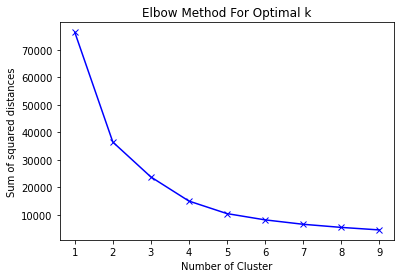

In [1627]:
#kmean to check the cluster based on the centroids
X = d_df.loc[:, ['Latitude', 'Longitude']]
sc = StandardScaler()
X_sc = sc.fit_transform(X)

#finding the most optimal number of 
sum_of_squared_distances = []
K = range(1,10)
for num_clusters in K :
    kmeans = KMeans(n_clusters=num_clusters)
    kmeans.fit(X_sc)
    sum_of_squared_distances.append(kmeans.inertia_)
plt.plot(K,sum_of_squared_distances,'bx-')
plt.xlabel('Number of Cluster') 
plt.ylabel('Sum of squared distances') 
plt.title('Elbow Method For Optimal k')
plt.show()

In [1628]:
#finding out top 5 clusters
km = KMeans(n_clusters=5, random_state=42)
km.fit(X_sc);

#centroids
km.cluster_centers_

array([[ 0.23698239,  0.14143195],
       [ 1.98877179, -0.70544285],
       [-0.38839889,  1.16738213],
       [-1.04634353,  0.2487438 ],
       [ 0.11343476, -1.85544551]])

In [1629]:
km.predict(X_sc)

array([0, 2, 2, ..., 0, 0, 0], dtype=int32)

In [1687]:
X['cluster'] = km.labels_
X.head()

,Latitude,Longitude,cluster
0,1.358639,103.845259,0
98,1.337496,103.934178,2
97,1.338017,103.935880,2
96,1.319943,103.884262,3
95,1.320944,103.883992,3


In [1688]:
## Create a dataframe for cluster_centers (centroids)
centroids = pd.DataFrame(
    sc.inverse_transform(km.cluster_centers_),
    columns=["Latitude", "Longitude"]
)
centroids

,Latitude,Longitude
0,1.365856,103.869084
1,1.435443,103.813465
2,1.341014,103.936463
3,1.314878,103.876131
4,1.360949,103.737939


<Figure size 504x504 with 0 Axes>

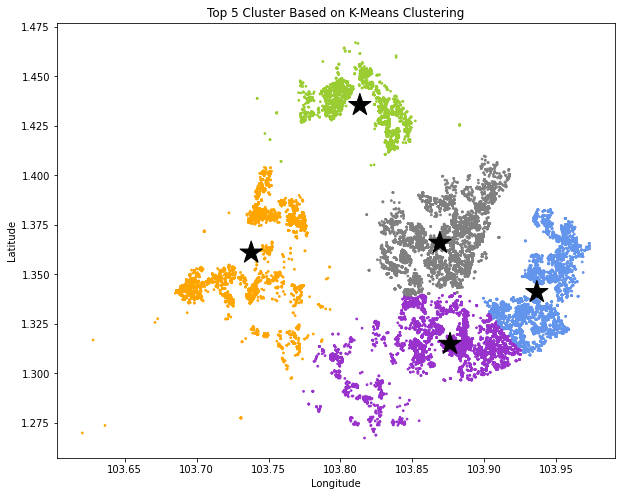

In [1690]:
plt.figure(figsize=(7,7));

## Plot scatter by cluster / color, and centroids
colors = ["grey", "yellowgreen", "cornflowerblue","darkorchid","orange"]
X['color'] = X['cluster'].map(lambda p: colors[p])

ax = X.plot(    
    kind="scatter", 
    x="Longitude", y="Latitude",
    figsize=(10,8),
    c = X['color'],s=3
)

centroids.plot(
    kind="scatter", 
    x="Longitude", y="Latitude", 
    marker="*", c=["k", "k", "k","k","k"], s=550,
    ax=ax
)
plt.title('Top 5 Cluster Based on K-Means Clustering');

# Correlation of the Features

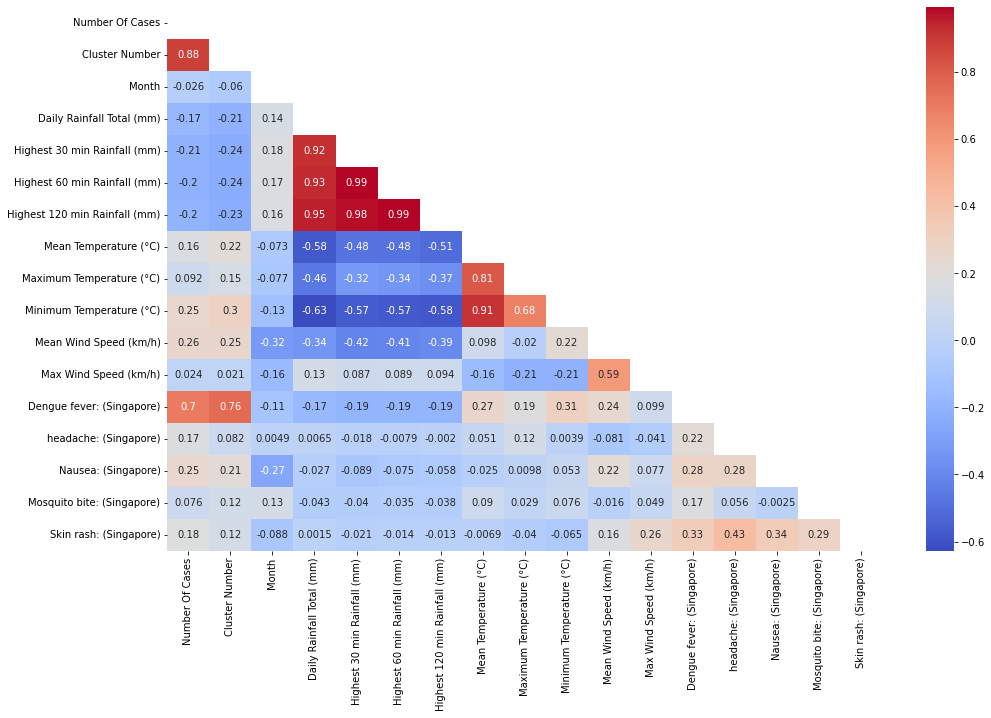

In [1691]:
# Checking the correlation
mask = np.zeros_like(df.corr())
mask[np.triu_indices_from(mask)] = True 
plt.figure(figsize=(16,10))
sns.heatmap(df.corr(),annot=True,cmap='coolwarm',mask=mask);

In [1693]:
df_check = df.reset_index()
df_check

,Date,County,Number Of Cases,Cluster Number,Month,Daily Rainfall Total (mm),Highest 30 min Rainfall (mm),Highest 60 min Rainfall (mm),Highest 120 min Rainfall (mm),Mean Temperature (°C),Maximum Temperature (°C),Minimum Temperature (°C),Mean Wind Speed (km/h),Max Wind Speed (km/h),Dengue fever: (Singapore),headache: (Singapore),Nausea: (Singapore),Mosquito bite: (Singapore),Skin rash: (Singapore)
0,2015-26,Central,172,9,7,6.463333,4.476667,5.250000,6.023333,28.555819,31.257000,25.332417,8.925417,37.106583,16.0,72.0,57.0,5.0,60.0
1,2015-26,Northeast,22,9,7,6.860000,5.540000,6.420000,6.850000,28.477763,31.337000,25.305750,8.788750,36.678250,16.0,72.0,57.0,5.0,60.0
2,2015-26,Northwest,34,10,7,5.417500,3.465000,4.105000,4.490000,28.631469,31.535000,25.303125,9.283125,38.316875,16.0,72.0,57.0,5.0,60.0
3,2015-26,Southeast,46,11,7,6.530909,4.341818,5.065455,5.689091,28.769282,31.212727,25.747727,9.427727,36.126818,16.0,72.0,57.0,5.0,60.0
4,2015-26,Southwest,13,4,7,4.781333,3.489333,3.965333,4.746667,28.628187,30.983200,25.612533,9.201333,37.508533,16.0,72.0,57.0,5.0,60.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
955,2019-51,Central,441,16,12,3.321429,2.809524,3.204762,3.297619,27.441610,31.662377,25.035790,11.638770,34.215672,17.0,69.0,64.0,5.0,71.0
956,2019-51,Northeast,225,13,12,1.442857,1.192857,1.278571,1.285714,27.396735,31.570455,24.868443,10.070212,31.558879,17.0,69.0,64.0,5.0,71.0
957,2019-51,Northwest,118,12,12,2.803571,1.700000,1.814286,1.921429,27.439048,31.558338,24.994463,12.913727,35.741398,17.0,69.0,64.0,5.0,71.0
958,2019-51,Southeast,78,7,12,1.059740,0.731169,0.840260,0.849351,27.615065,31.532227,25.332617,11.513116,34.321398,17.0,69.0,64.0,5.0,71.0


In [1694]:
from pandas_profiling.visualisation.plot import timeseries_heatmap

timeseries_heatmap(dataframe=df_check, entity_column='D', sortby='Date')

KeyError: "['Number of Cases'] not in index"

# Time Series Analysis


In [ ]:
c_df.head()

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GRU
from tensorflow.keras.optimizers import Adam
from keras import metrics
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

import matplotlib.pyplot as plt

In [ ]:
c_df.describe()

In [ ]:
c_df

In [ ]:
features = [col for col in c_df.columns if not col == 'red_county']
X = c_df[features]
y = c_df[['red_county']].values

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False)
ss = StandardScaler()
X_train_sc = ss.fit_transform(X_train)
X_test_sc = ss.transform(X_test)

In [ ]:
train_sequences = TimeseriesGenerator(X_train_sc, y_train, length=3, batch_size=64)
test_sequences = TimeseriesGenerator(X_test_sc, y_test, length=3, batch_size=64)
batch_x, batch_y = train_sequences[0]

In [ ]:
pd.DataFrame(X_train_sc, columns=X_train.columns).head(3)

In [ ]:
train_sequences[0][0].shape

In [ ]:
input_shape = train_sequences[0][0][0].shape
model = Sequential()
model.add(GRU(8, input_shape=input_shape, return_sequences=True)) # True if next layer is RNN, 8 is GRU when you unrolled 
model.add(GRU(8, return_sequences=False)) # False if next layer is Dense

model.add(Dense(4, activation='relu'))

model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=Adam(lr=.0005), loss='bce', metrics=['acc'])

history = model.fit(train_sequences, validation_data=test_sequences, epochs=50, verbose=0)
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Test loss') #overfit as test loss starts to increase
plt.legend();

In [ ]:
model.predict(test_sequences)

In [ ]:
y_test

In [ ]:
plt.plot(history.history['acc'], label='Train accuracy')
plt.plot(history.history['val_acc'], label='Test accuracy')
plt.legend();

In [ ]:
y_pred = model.evaluate(X_train_sc)
metrics.accuracy(y_train, y_pred)

In [ ]:
import matplotlib.dates as mdates

# Plot
fig, ax = plt.subplots(nrows=4,ncols=1,figsize=(30,5))
ax = ax.ravel()
c_df.plot(x='Date', y='Number Of Cases', marker='.', ax=ax[0])
c_df.plot(x='Date', y='Mean Temperature (°C)', marker='.', ax=ax[1])
c_df.plot(x='Date', y='Mean Wind Speed (km/h)', marker='.', ax=ax[2])
c_df.plot(x='Date', y='Daily Rainfall Total (mm)', marker='.', ax=ax[3])

# Format the x-ticks
myFmt = mdates.DateFormatter('%Y week %U')
for i in [0,1]:
    for j in [0,1]:
        ax[i,j].xaxis.set_major_formatter(myFmt)

In [ ]:
df.set_index('date', inplace=True)

y_m = df['number'].resample('M').mean()
result = seasonal_decompose(y_m, model='additive') # additive
fig = result.plot()

In [ ]:
result = seasonal_decompose(y_m, model='multiplicative') # multiplicative
fig = result.plot()

### Findings: 
Time serires is seasonal. Thus, SARIMA is suitable.

In [ ]:
# Plot to check if diff data series is stationary

fig, ax = plt.subplots(2,2,figsize=(15, 15))
data.plot( y='number',use_index=True, marker='.', ax=ax[0,0])
data.plot( y='avg rainfall',use_index=True, marker='.', ax=ax[0,1])
data.plot( y='avg temperature',use_index=True, marker='.', ax=ax[1,0])
data.plot( y='avg wind speed',use_index=True, marker='.', ax=ax[1,1])

fig.tight_layout(pad=5.0)

# Format the x-ticks
myFmt = mdates.DateFormatter('%Y week %U')
for i in [0,1]:
    for j in [0,1]:
        ax[i,j].xaxis.set_major_formatter(myFmt)

### Granger Causality Test to investigate causality of data. 

Granger causality is a way to investigate the causality between two variables in a time series which actually means if a particular variable comes before another in the time series. In the MTS, we will test the causality of all combinations of pairs of variables.

##### Granger Causality Hypothesis:
* H0 (Null Hypothesis) : lagged x-values do not explain the variation in y, so the x does not cause y. 
* H1 (Alternative Hypothesis) : x causes y

We use grangercausalitytests function in the package statsmodels to do the test and the output of the matrix is the minimum p-value when computes the test for all lags up to maxlag(=22). The critical value we use is 5% and if the p-value of a pair of variables is smaller than 0.05, we could say with 95% confidence that a predictor x causes a response y.

In [ ]:
from statsmodels.tsa.stattools import grangercausalitytests

variables=data.columns  
matrix = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
maxlag=22

for col in matrix.columns:
    for row in matrix.index:
        test_result = grangercausalitytests(data[[row, col]], maxlag=24, verbose=False)            
        p_values = [round(test_result[i+1][0]['ssr_chi2test'][1],4) for i in range(maxlag)]            
        min_p_value = np.min(p_values)
        matrix.loc[row, col] = min_p_value
matrix.columns = [var + '_x' for var in variables]
matrix.index = [var + '_y' for var in variables]

matrix

#### Findings:
From the result above, each column represents a predictor x of each variable and each row represents the response y and the p-value of each pair of variables are shown in the matrix.
 
Take the value 0.0052 (<0.05) in (row 3, column 1) and 0.0149 (<0.05) in (row 3, column 3):

Because  p<0.05, we reject H0 (x-values do not explain the variation in y). In other words, it suggests that avg rainfall and avg wind speed is causal to avg dengue case numbers !

Thus Vector Arima could be helpful to modelling this time series.

### Stationary Test
As VectorARIMA requires time series to be stationary, we will use one popular statistical test – Augmented Dickey-Fuller Test (ADF Test) to check the stationary of each variable in the dataset.  

The Null Hypothesis is that the data has unit root and is not stationary and the significant value is 0.05.

In [ ]:
from statsmodels.tsa.stattools import adfuller

def adfuller_test(series, sig=0.05, name=''):
    res = adfuller(series, autolag='AIC')    
    p_value = round(res[1], 5) 
    if p_value <= sig:
        print(f" {name} : P-Value = {p_value} => Stationary. ")
    else:
        print(f" {name} : P-Value = {p_value} => Non-stationary.")
        
for name, column in data.iteritems():
    adfuller_test(column, name=column.name)

#### Findings:
From the results above, we could see none of these varibles is stationary. Let us use the differencing method to make them stationary.

In [ ]:
df

In [ ]:
data

In [ ]:
type(data.index)

In [ ]:
#data.index = data.index.to_period('W')
data

## Train-Test Split

In [ ]:
test_obs = int(len(data) * 0.2)
train = data[:-test_obs]
test = data[-test_obs:]

# for ARIMA
endog = train[['number']]
exog = train[['avg rainfall','avg temperature','avg wind speed']]
test_exog = data[-test_obs:][['avg rainfall','avg temperature','avg wind speed']]

In [ ]:
# Generate autocorrelation plot on training data.
fig, ax = plt.subplots(2,1,figsize=(15, 15))
plot_acf(train['number'], lags = 20,ax=ax[0]);
plot_pacf(train['number'], lags = 20,ax=ax[1]);

#### Findings: 
Both the ACF and PACF show a gradual decay, an ARMA model is likely appropriate as opposed to AR or MA alone. Since there are multiple variables, I will use vector ARIMA model to fit data.

## Model

### Vector Auto Regression (VAR)
https://www.analyticsvidhya.com/blog/2018/09/multivariate-time-series-guide-forecasting-modeling-python-codes/#:~:text=A%20Multivariate%20time%20series%20has,used%20for%20forecasting%20future%20values.

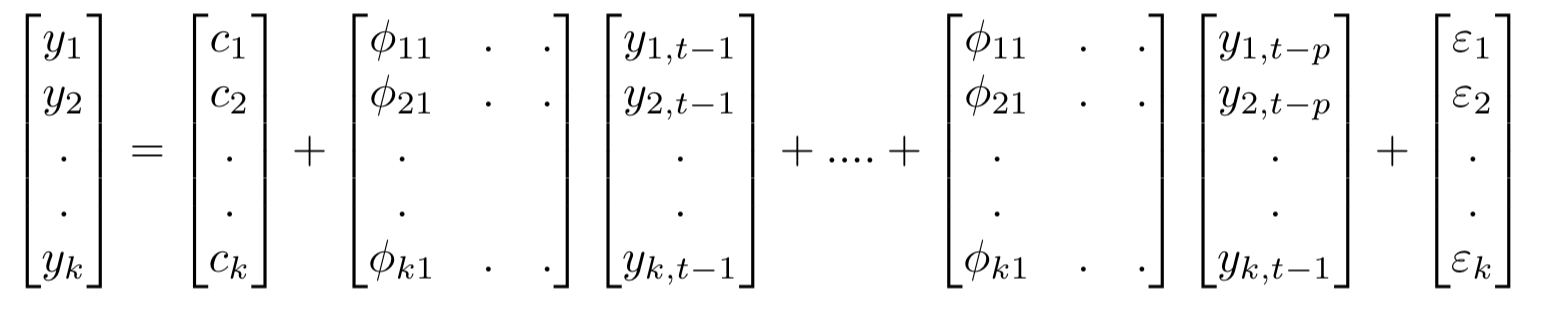

In [ ]:
model = VAR(train)

In [ ]:
x = model.select_order(maxlags=16)
x.summary()

In [ ]:
results_aic = []
results_bic = []
results_hqic = []
for p in range(1,10):
    results = model.fit(p)
    results_aic.append(results.aic)
    results_bic.append(results.bic)
    results_hqic.append(results.hqic)

In [ ]:
#define subplots
fig,ax = plt.subplots()
#add first line to plot
ax.plot(list(np.arange(1,10,1)), results_aic)
#add x-axis label
ax.set_xlabel('Order', fontsize=14)
#add y-axis label
ax.set_ylabel('AIC', fontsize=16)

#define second y-axis that shares x-axis with current plot
ax2 = ax.twinx()
#add second line to plot
ax2.plot(list(np.arange(1,10,1)), results_bic, color='red')
#add second y-axis label
ax2.set_ylabel('BIC', fontsize=16)

#define third y-axis that shares x-axis with current plot
ax3 = ax.twinx()
#add third line to plot
ax3.plot(list(np.arange(1,10,1)), results_hqic, color ='Purple')
#add third y-axis label
ax2.set_ylabel('HQIC', fontsize=16)

In [ ]:
p = 7
#p = 6
results =  model.fit(p)
# results.summary()

In [ ]:
# make predictions
pred = results.forecast(results.endog, steps = test_obs)
pred = pd.DataFrame(pred, columns = data.columns + '_pred')
#pred

In [ ]:
d = data.tail(test_obs)
pred.index = d.index

In [ ]:
def plot_forecast_actuals(data, data_actual, data_predict):
    fig, axes = plt.subplots(nrows=int(len(data_actual.columns)/2), ncols=2, dpi=120, figsize=(8,5))
    for i, (col,ax) in enumerate(zip(data_actual.columns, axes.flatten())):
        ax.plot(list(np.arange(1,test_obs+1,1)),data_predict[col + '_pred'], label='forecast', marker='o')
        ax.plot(list(np.arange(1,test_obs+1,1)),data_actual[col], label='actual values', marker='x')
        ax.legend(loc='best')
        ax.set_title(data.columns[i])
        ax.set_title(col)
        ax.tick_params(labelsize=6)
    
    plt.tight_layout();
    
plot_forecast_actuals(data=data, data_actual=test, data_predict = pred)

In [ ]:
def invert_transformation(endog_train,pred):
    forecast = pred.copy()
    columns = endog_train.columns
    for col in columns:
        forecast[str(col)+'_pred'] = endog_train[col].iloc[-1] +   forecast[str(col) +'_pred'].cumsum()
    return forecast

output = invert_transformation( df[['avg rainfall','avg temperature','avg wind speed','number']].head(len(df)-test_obs-1), pred)

plot_forecast_actuals(data=data, data_actual=df[['avg rainfall','avg temperature','avg wind speed','number']].tail(test_obs), data_predict = output)

In [ ]:
# Plot data.
fig, ax = plt.subplots(1, 1, figsize=(15, 5))

# Plot training data in blue.
plt.plot(train['number'], color = 'blue')

# Plot testing data in orange.
plt.plot(test['number'], color = 'orange')

# Plot predicted values in green.
plt.plot(pred['number_pred'], color = 'green')

plt.title(label = 'Dengue Weekly Diff Volume', fontsize=18)
plt.show();

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
plt.plot(df['number'], color = 'blue')
plt.plot(df['number'].tail(test_obs), color = 'orange')
plt.plot(output['number_pred'], color = 'green')         
plt.title(label = f'Dengue Weekly Volume with VarARIMA({p}) Predictions', fontsize=18)
plt.show();

In [ ]:
# Evaluate predictions.
mean_squared_error(test['number'], pred['number_pred'])

In [ ]:
mean_squared_error(df['number'][-test_obs:], output['number_pred'])

In [ ]:
res1 =  pd.concat([test,pred['number_pred']],axis=1)
res1[['number','number_pred']].plot()
res1['diff'] = res1['number']-res1['number_pred']


In [ ]:
# residual plot
var_res = pd.concat([results.resid['number'], res1['diff']])
plt.plot(var_res)

## Findings:
The residual plot depicts variance change, which indicates that model variance is not constant over time.
To tackle with conditional variance, we will use GARCH model (arch package in python). 

## ARIMA (Poor perfomance model)

In [ ]:
import warnings
warnings.filterwarnings("ignore")

#p=9
#q=[9,17]
#i=[1,2]
# Starting AIC, p, and q.
best_aic = float('inf')
best_p = 0
best_q = 0

# Use nested for loop to iterate over values of p and q.
for p in range(8):
    for q in range(8):
        
        # Instantiate ARIMA model.
        arima = ARIMA(endog = endog, exog = exog, order=(p, 1, q))
        
        
        # Fit ARIMA model.
        model = arima.fit()

        # Is my current model's AIC better than our best_aic?
        if model.aic < best_aic:
            
            # If so, let's overwrite best_aic, best_p, and best_q.
            best_aic = model.aic
            best_p = p
            best_q = q


        #except:
            #print('err')
            #pass
print('MODEL FINISHED!')
print(f'Our model that minimizes AIC on the training data is the ARIMA({best_p},1,{best_q}).')
print(f'This model has an AIC of {best_aic}.')

In [ ]:
ma1 = ARIMA(endog = endog, exog = exog, order=(best_p, 1, best_q))
model = ma1.fit()

# Generate predictions based on test set.
preds = model.predict(exog = test_exog, start=len(data)-test_obs, end=len(data)-1)

# Evaluate predictions.
mean_squared_error(test['number'], preds)

In [ ]:
pred1 = preds.to_frame()
pred1 = pred1.rename(columns= {'predicted_mean': 'number_pred'})
pred1.index = d.index
#pred1

In [ ]:
# Plot data.
fig, ax = plt.subplots(1, 1, figsize=(15, 5))

# Plot training data in blue.
plt.plot(train['number'], color = 'blue')

# Plot testing data in orange.
plt.plot(test['number'], color = 'orange')

# Plot predicted values in green.
plt.plot(pred1['number_pred'], color = 'green')

plt.title(label = 'Dengue Weekly Diff Volume', fontsize=18)
plt.show();

In [ ]:

outputs1 = invert_transformation(endog, pred1)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
plt.plot(df['number'], color = 'blue')
plt.plot(df['number'].tail(test_obs), color = 'orange')
plt.plot(outputs1, color = 'green')         
plt.title(label = f'Dengue Weekly Volume with ARIMA({best_p},1,{best_q}) Predictions', fontsize=18)
plt.show();

In [ ]:
mean_squared_error(df['number'][-test_obs:], outputs1)

## Findins:
From the plot we can see ARIMA performs poorly and predicts rediculous results.

## SARIMA

In [ ]:
sarima_model1 = auto_arima(
                        y=endog, 
                        X=exog,
                        start_p=1, 
                        start_q=1,
                        max_p=8, 
                        max_q=8, 
                        m=4,    # quaterly
                        start_P=0, 
                        max_P = 4,
                        max_Q = 4,
						seasonal=True,
                        d=1, 
                        #D=1, 
                        trace=True,
                        error_action='ignore',
                        suppress_warnings=True,
                        stepwise=True)

In [ ]:
sarima_model1.summary()

### Findings
According to the model summary, the model meets the condition of independence in the residuals (no correlation) because the p-value of the Ljung-Box test (Prob(Q)) is not greater than 0.05, so we reject the null hypothesis of independence, which means the residual distribution is not homoscedastic (constant variance) because the p-value of the Heteroskedasticity test (Prob(H)) is 0, smaller than 0.05.

In [ ]:
forecast,confint = sarima_model1.predict(n_periods= test_obs, X = test_exog, return_conf_int=True)
forecast = pd.DataFrame(forecast,columns=['number_pred'])
forecast.index=test.index
#forecast

In [ ]:
res = pd.concat([test,forecast],axis=1)
res[['number','number_pred']].plot()
res['diff'] = res['number']-res['number_pred']


In [ ]:
pred2 = invert_transformation(endog, res[['number_pred']])
cf= pd.DataFrame(confint)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))

# Plot training data in blue.
plt.plot(train['number'], color = 'blue')

# Plot testing data in orange.
plt.plot(test['number'], color = 'orange')

# Plot predicted values in green.
plt.plot(res['number_pred'], color = 'green')

ax.fill_between(forecast.index,
                cf[0],
                cf[1],color='grey',alpha=.3)
                
plt.title(label = 'Dengue Weekly Diff Volume', fontsize=18)
plt.show();

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))

plt.plot(df['number'], color = 'blue')
plt.plot(df['number'].tail(test_obs), color = 'orange')
plt.plot(pred2, color = 'green')
      
plt.title(label = f'Dengue Weekly Volume with SARIMA(3,1,0)(4,0,0)[4] Predictions', fontsize=18)
plt.show();

In [ ]:
mean_squared_error(test['number'], res[['number_pred']])

In [ ]:
mean_squared_error(df['number'][-test_obs:], pred2)

In [ ]:
sarima_model1.plot_diagnostics(figsize=(14,10))
plt.show()

## Findings:
We can see from the model plots that the Correlogram does not show any significant correlation in the residuals. The standardized residual plot depicts variance change, which indicates that model variance is not constant over time while the normal Q-Q plot demonstrates that the residuals do not follow a normal distribution. 

To tackle with conditional variance, we will use GARCH model (arch package in python). 

## GARCH



variance of GARCH:

\begin{aligned}

   \sigma^2_{t+1} & = & \omega + \alpha \epsilon_t^2 + \beta \sigma^2_t \\
   \sigma^2_{t+h} & = & \omega + \alpha  E_{t}[\epsilon_{t+h-1}^2] + \beta E_{t}[\sigma^2_{t+h-1}] \, h \geq 2 \\
                  & = & \omega + \left(\alpha  + \beta\right) E_{t}[\sigma^2_{t+h-1}] \, h \geq 2
\end{aligned} 

GARCH(1,1) Model:

\begin{aligned}
   r_t        & =    & \mu + \epsilon_t \\
   \epsilon_t & =    & \sigma_t e_t \\
   \sigma^2_t & =    & \omega + \alpha \epsilon_{t-1}^2 + \beta \sigma^2_{t-1} \\
   e_t        & \sim & N(0,1)
\end{aligned} 

## SARIMA + GARCH

In [ ]:
sarima_residuals = sarima_model1.arima_res_.resid
full_residuals = pd.concat([sarima_residuals ,res['diff']])

In [ ]:
full_residuals

In [ ]:
train[-1:]

In [ ]:
start_date = train[-1:].index.to_pydatetime()[0]
start_date 

In [ ]:
plt.plot(full_residuals)

In [ ]:
rsd = full_residuals.resample('M').mean()
result = seasonal_decompose(rsd, model='additive') # additive
fig = result.plot()

In [ ]:
rsd

In [ ]:
# Generate autocorrelation plot on training data.
fig, ax = plt.subplots(2,1,figsize=(15, 15))
plot_acf(full_residuals, lags = 20,ax=ax[0]);
plot_pacf(full_residuals, lags = 20,ax=ax[1]);

In [ ]:
def grid_search_garch(res_data):    
    # Starting AIC, p, o and q.
    best_aic = float('inf')
    best_p = float('inf')
    best_q = float('inf')

    # Use nested for loop to iterate over values of p and q.
    for p in range(1,6):
        for q in range(1,6):
        
            # Instantiate ARIMA model.
            garch = arch_model(res_data, vol='Garch', p=p, q=q, x=exog)
            
            # Fit ARIMA model.
            garch_fitted = garch.fit(last_obs=start_date)

            # Is my current model's AIC better than our best_aic?
            if garch_fitted.aic < best_aic:
                
                # If so, let's overwrite best_aic, best_p, and best_q.
                best_aic = garch_fitted.aic
                best_p = p
                best_q = q
                best_o = o

    print('MODEL FINISHED!')
    print(f'Our model that minimizes AIC on the training data is the GARCH({best_p}, {best_q}).')
    print(f'This model has an AIC of {best_aic}.')


In [ ]:

grid_search_garch(full_residuals)

In [ ]:
# fit a GARCH(1,3) model on the residuals of the ARIMA model
garch = arch_model(full_residuals, vol='Garch', p=1, o=1, q=3, x=exog)
garch_fitted = garch.fit(last_obs=start_date)

# Use GARCH to predict the residual
garch_forecast = garch_fitted.forecast(horizon=test_obs,start=start_date)

In [ ]:
print(garch_forecast.mean['h.01'][start_date:])
#print(garch_forecast.mean[start_date:])

In [ ]:
garch_forecast.variance['h.01'].tail()

In [ ]:
garch_fitted.summary()

In [ ]:
fig = garch_fitted.plot()

In [ ]:
# Use ARIMA to predict mu


In [ ]:
grid_search_garch(var_res)

In [ ]:
# fit a GARCH(1,2) model on the residuals of the ARIMA model
garch = arch_model(var_res, vol='Garch', p=1, o=1, q=2, x=exog)
garch_fitted = garch.fit(last_obs=start_date)

# Use GARCH to predict the residual
garch_forecast = garch_fitted.forecast(horizon=test_obs,start=start_date)

In [ ]:
garch_fitted.summary()

In [ ]:
fig = garch_fitted.plot()

In [ ]:
print(garch_forecast.mean['h.01'][start_date - dt.timedelta(8):])

In [ ]:
res1['pred2'] = round (res1['number_pred'] + 0.18)
res1[['number','number_pred','pred2']].plot()

In [ ]:
pred['number_pred'] = res1['pred2']

In [ ]:
output2 = invert_transformation( df[['avg rainfall','avg temperature','avg wind speed','number']].head(len(df)-test_obs-1), pred)
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
plt.plot(df['number'], color = 'blue')
plt.plot(df['number'].tail(test_obs), color = 'orange')
plt.plot(output['number_pred'], color = 'red') 
plt.plot(output2['number_pred'], color = 'green')         
plt.title(label = f'Dengue Weekly Volume with VarARIMA({p}) Predictions', fontsize=18)
plt.show();

In [ ]:
mean_squared_error(df['number'][-test_obs:], output2['number_pred'])

In [ ]:
print(f" The improvement in mean squared error is {mean_squared_error(df['number'][-test_obs:], output['number_pred'])-mean_squared_error(df['number'][-test_obs:], output2['number_pred'])}")